In [125]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn

import zipfile
import time
import os
import io
from scipy.stats import pearsonr

<h3> 1. Informações de desmatamento </h3>

In [126]:
df_desmatamento = pd.read_csv('br_inpe_prodes_municipio_bioma.csv')
df_desmatamento.head(3)

,ano,id_municipio,bioma,area_total,desmatado,vegetacao_natural,nao_vegetacao_natural,hidrografia
0,2012,1707207,Amazônia,0,61.9,-62.1,0.2,0.0
1,2004,1707207,Amazônia,0,60.0,-60.2,0.2,0.0
2,2015,1707207,Amazônia,0,61.9,-62.1,0.2,0.0


In [127]:
df_desmatamento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150328 entries, 0 to 150327
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ano                    150328 non-null  int64  
 1   id_municipio           150328 non-null  int64  
 2   bioma                  150328 non-null  object 
 3   area_total             150328 non-null  int64  
 4   desmatado              150328 non-null  float64
 5   vegetacao_natural      150328 non-null  float64
 6   nao_vegetacao_natural  150328 non-null  float64
 7   hidrografia            150328 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 9.2+ MB


In [128]:
# puxar nome da cidade
df_municipios = pd.read_csv('cod_mun.csv', delimiter=';')
df_desmatamento = df_desmatamento.merge(df_municipios, left_on='id_municipio', right_on='COD_MUN_EFD')
df_desmatamento = df_desmatamento[['ano', 'id_municipio', 'Nome_Município', 'bioma', 'area_total', 'desmatado',
       'vegetacao_natural', 'nao_vegetacao_natural', 'hidrografia']]

In [129]:
# incluir a unidade de medida de cada coluna
df_desmatamento.rename(columns={'area_total': 'area_total_km2', 'desmatado': 'desmatado_km2', 'Nome_Município':  'município', 'vegetacao_natural': 'vegetacao_natural_km2', 'nao_vegetacao_natural': 'nao_vegetacao_natural_v2', 'hidrografia': 'hidrografia_km2'},inplace=True)

In [130]:
# qual a proporção de área desmatada por bioma?
df_desmatamento_bioma = df_desmatamento.groupby('bioma')[['desmatado_km2','area_total_km2']].sum()
df_desmatamento_bioma['proporcao_desmatada'] = (df_desmatamento_bioma['desmatado_km2']/df_desmatamento_bioma['area_total_km2']).round(2)
df_desmatamento_bioma.sort_values(by='proporcao_desmatada',ascending=False,inplace=True)
df_desmatamento_bioma['desmatado_km2'] = df_desmatamento_bioma['desmatado_km2'].astype(int)
df_desmatamento_bioma = df_desmatamento_bioma.style.format({
    'desmatado_km2': '{:,.0f}'.format,
    'area_total_km2': '{:,.0f}'.format,
    'proporcao_desmatada': '{:.2}'.format
})
df_desmatamento_bioma

,desmatado_km2,area_total_km2,proporcao_desmatada
bioma,,,
Mata Atlântica,"17,691,627","25,421,923",0.7
Pampa,"2,295,051","4,155,088",0.55
Cerrado,"20,520,013","45,628,573",0.45
Caatinga,"7,544,136","19,826,851",0.38
Amazônia,"15,066,884","96,815,671",0.16
Pantanal,"522,872","3,471,850",0.15


Text(0.5, 0, '')

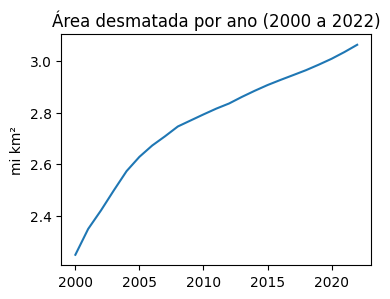

In [131]:
# qual a área desmatada por ano?
df_desmatamento_ano = df_desmatamento.groupby('ano')['desmatado_km2'].sum().reset_index()

graph = df_desmatamento_ano.plot.line(x='ano',y='desmatado_km2',figsize=(4,3),title='Área desmatada por ano (2000 a 2022)',legend=False,ylabel='mi km²')
graph.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x / 1e6:.1f}'))
graph.set_xlabel('')

<hr>

<h3> 2. Informações de temperatura média </h3>

https://www.kaggle.com/datasets/maxwelfreitas/daily-max-and-min-temperatures-southeast-brazil

In [96]:
df_temp = pd.read_csv('daily_min_max_temp_br_se.csv',dtype={'station_name':str, 'max_temperature': float})
df_temp.head(5)

C:\Users\bserpellone\AppData\Local\Temp\ipykernel_8280\3491921984.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv('daily_min_max_temp_br_se.csv',dtype={'station_name':str, 'max_temperature': float})


,station_name,station_id,latitude,longitude,altitude,measure_date,max_temperature,min_temperature
0,ALTO DA BOA VISTA,83007,-22.965833,-43.279167,347.1,2000-01-01,31.4,21.2
1,ALTO DA BOA VISTA,83007,-22.965833,-43.279167,347.1,2000-01-02,26.8,21.0
2,ALTO DA BOA VISTA,83007,-22.965833,-43.279167,347.1,2000-01-03,NaN,19.9
3,ALTO DA BOA VISTA,83007,-22.965833,-43.279167,347.1,2000-01-04,NaN,21.2
4,ALTO DA BOA VISTA,83007,-22.965833,-43.279167,347.1,2000-01-05,33.4,20.7


In [97]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1619299 entries, 0 to 1619298
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   station_name     1619299 non-null  object 
 1   station_id       1619299 non-null  object 
 2   latitude         1619299 non-null  float64
 3   longitude        1619299 non-null  float64
 4   altitude         1619299 non-null  float64
 5   measure_date     1619299 non-null  object 
 6   max_temperature  1395282 non-null  float64
 7   min_temperature  1399893 non-null  float64
dtypes: float64(5), object(3)
memory usage: 98.8+ MB


In [98]:
df_temp['measure_date'] = pd.to_datetime(df_temp['measure_date'],format='%Y-%m-%d')
df_temp['ano'] = df_temp['measure_date'].dt.year
df_temp = df_temp[df_temp['ano']<=2022]
df_temp['max_temperature'] = df_temp.groupby('ano')['max_temperature'].transform(
    lambda x: x.fillna(x.mean()))

In [135]:
anos_totais = df_temp['ano'].nunique()
stations_completas = df_temp.groupby('station_name')['ano'].nunique()
stations_completas = stations_completas[stations_completas == anos_totais].index
df_temp_filtrado = df_temp[df_temp['station_name'].isin(stations_completas)]
df_temp_filtrado

,station_name,station_id,latitude,longitude,altitude,measure_date,max_temperature,min_temperature,ano
0,ALTO DA BOA VISTA,83007,-22.965833,-43.279167,347.1,2000-01-01,31.400000,21.2,2000
1,ALTO DA BOA VISTA,83007,-22.965833,-43.279167,347.1,2000-01-02,26.800000,21.0,2000
2,ALTO DA BOA VISTA,83007,-22.965833,-43.279167,347.1,2000-01-03,28.510082,19.9,2000
3,ALTO DA BOA VISTA,83007,-22.965833,-43.279167,347.1,2000-01-04,28.510082,21.2,2000
4,ALTO DA BOA VISTA,83007,-22.965833,-43.279167,347.1,2000-01-05,33.400000,20.7,2000
...,...,...,...,...,...,...,...,...,...
1612878,SAO SIMAO,A770,-21.461111,-47.579444,620.0,2022-12-27,28.800000,21.1,2022
1612879,SAO SIMAO,A770,-21.461111,-47.579444,620.0,2022-12-28,27.800000,19.5,2022
1612880,SAO SIMAO,A770,-21.461111,-47.579444,620.0,2022-12-29,28.300000,19.2,2022
1612881,SAO SIMAO,A770,-21.461111,-47.579444,620.0,2022-12-30,29.100000,20.4,2022


Text(0.5, 0, '')

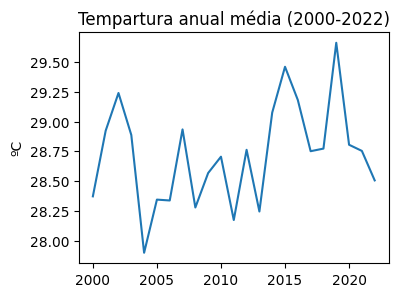

In [136]:
df_temp_agrupado = df_temp_filtrado.groupby('ano')['max_temperature'].mean()
graph = df_temp_agrupado.plot.line(x='ano',y='max_temperature',figsize=(4,3),title='Tempartura anual média (2000-2022)',legend=False,ylabel='ºC')
graph.set_xlabel('')

In [137]:
df_temp_agrupado.round(2)

ano
2000    28.37
2001    28.92
2002    29.24
2003    28.89
2004    27.90
2005    28.35
2006    28.34
2007    28.93
2008    28.28
2009    28.57
2010    28.71
2011    28.18
2012    28.76
2013    28.25
2014    29.07
2015    29.46
2016    29.18
2017    28.75
2018    28.77
2019    29.66
2020    28.81
2021    28.75
2022    28.51
Name: max_temperature, dtype: float64

<hr>

<h3>3. Teste de hipótese</h3>

In [138]:
df_combined = pd.merge(df_desmatamento_ano, df_temp_agrupado, left_on='ano', right_on='ano')
corr, p_value = pearsonr(df_combined['desmatado_km2'], df_combined['max_temperature'])
if p_value < 0.05:
    print("Rejeitamos a hipótese nula: há uma correlação significativa entre desmatamento e temperatura.")
else:
    print("Não rejeitamos a hipótese nula: não há uma correlação significativa entre desmatamento e temperatura.")

Não rejeitamos a hipótese nula: não há uma correlação significativa entre desmatamento e temperatura.


In [139]:
p_value

0.3292022376379423

In [140]:
corr

0.21298227641679168